In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Let us consider the function:

$$f : \mathbb{R}^2 \rightarrow \mathbb{R}; \qquad x \rightarrow 2\sin (x_1) - 3\cos (x_2)$$

restricted to the box range:

\begin{equation}
x_1 \in [-2, 2], x_2 \in [-2, 2].
\end{equation}


We have a training and a test datasets with 500 samples each, uniformly sampled within the domain. Samples are corrupted with an additive Gaussian noise with standard deviation $\sigma_e = 0.1$

We reconstruct the function using a MLP characterized by
* 2 input channels and 1 input channel - not a choice, this is the structure of $f(x)$: 
* 2 hidden layers
* 32 neurons in the first layer, 16 neurons in the second layer
* $\tanh$ activation function 

In [2]:
# Constants

n_x = 2 # number of inputs
n_y = 1 # number of outputs
a = -2.0 # lower bound x_1/x_2
b = 2.0 # upper bound x_1/x_2
n_samples = 500 # number of samples in the training/test datasets
sigma_e = 0.1 # standard deviation of the noise
grid_points = 100 # number of points in the grid for the plot

In [3]:
# Function definition

def f(x):
    return 2*torch.sin(x[..., 0])  - 3*torch.cos(x[..., 1]) # ellipses used to handle an optional "batch" dimension
# f(torch.tensor([0.2, 0.4])), 2*np.sin(0.2) - 3*np.cos(0.4) # test

In [4]:
# Generate synthetic data

x1_train = a + torch.rand(n_samples)*(b - a)
x2_train = a + torch.rand(n_samples)*(b - a)
X_train = torch.stack([x1_train, x2_train], dim=-1)

y_train = f(X_train) + sigma_e * torch.randn(n_samples)
y_train = y_train.view(-1, 1)
X_train.shape, y_train.shape 

(torch.Size([500, 2]), torch.Size([500, 1]))

In [5]:
x1_test = a + torch.rand(n_samples)*(b - a)
x2_test = a + torch.rand(n_samples)*(b - a)
X_test = torch.stack([x1_test, x2_test], dim=-1)

y_test = f(X_test) + sigma_e * torch.randn(n_samples)
y_test = y_test.view(-1, 1)
X_test.shape, y_test.shape 

(torch.Size([500, 2]), torch.Size([500, 1]))

In [6]:
# Visualize the true function - impossible in real-world problems and in higher dimensions!

x1_grid = np.linspace(a, b, grid_points)
x2_grid = np.linspace(a, b, grid_points)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid)
X_grid = torch.tensor(np.c_[X1_grid.ravel(), X2_grid.ravel()], dtype=torch.float32)
y_grid = f(X_grid)
X_grid.shape, X1_grid.shape, X2_grid.shape, y_grid.shape

(torch.Size([10000, 2]), (100, 100), (100, 100), torch.Size([10000]))

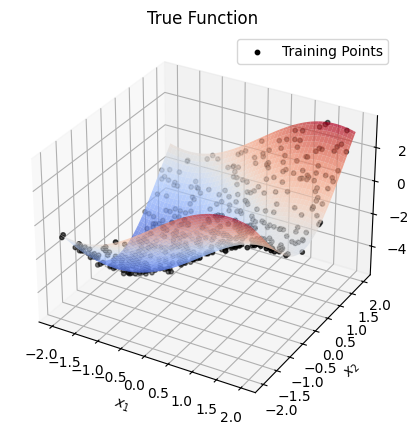

In [7]:
# 3D Plot of True Function
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_grid, X2_grid, y_grid.view(100, 100).numpy(), cmap='coolwarm', alpha=0.7)#, edgecolor='none')
ax1.set_title("True Function")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.scatter(X_train[:, 0].numpy(), X_train[:, 1].numpy(), y_train[:, 0].numpy(), color='k', s=10, label='Training Points')
ax1.legend()
ax1.set_zlabel("$y$")
plt.show()

In [8]:
# Define a simple neural network

class FeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_x, 16) 
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(16, 8)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(8, n_y)

    def forward(self, x):
        x = self.act1(self.fc1(x)) # 16
        x = self.act2(self.fc2(x)) # 8
        x = self.fc3(x) # 1
        return x

model = FeedForwardNN()



In [9]:
# Optimization loop

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
iters = 5000
LOSS = []
for iter in range(iters):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    LOSS.append(loss.item())
    if iter % 100 == 0:
        print(f"Epoch {iter}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 6.7608
Epoch 100: Loss = 3.3448
Epoch 200: Loss = 1.8570
Epoch 300: Loss = 1.1538
Epoch 400: Loss = 0.5303
Epoch 500: Loss = 0.2587
Epoch 600: Loss = 0.1692
Epoch 700: Loss = 0.1162
Epoch 800: Loss = 0.0830
Epoch 900: Loss = 0.0623
Epoch 1000: Loss = 0.0489
Epoch 1100: Loss = 0.0399
Epoch 1200: Loss = 0.0336
Epoch 1300: Loss = 0.0290
Epoch 1400: Loss = 0.0257
Epoch 1500: Loss = 0.0231
Epoch 1600: Loss = 0.0212
Epoch 1700: Loss = 0.0197
Epoch 1800: Loss = 0.0186
Epoch 1900: Loss = 0.0177
Epoch 2000: Loss = 0.0170
Epoch 2100: Loss = 0.0165
Epoch 2200: Loss = 0.0160
Epoch 2300: Loss = 0.0156
Epoch 2400: Loss = 0.0152
Epoch 2500: Loss = 0.0148
Epoch 2600: Loss = 0.0145
Epoch 2700: Loss = 0.0142
Epoch 2800: Loss = 0.0139
Epoch 2900: Loss = 0.0136
Epoch 3000: Loss = 0.0134
Epoch 3100: Loss = 0.0131
Epoch 3200: Loss = 0.0129
Epoch 3300: Loss = 0.0127
Epoch 3400: Loss = 0.0125
Epoch 3500: Loss = 0.0123
Epoch 3600: Loss = 0.0121
Epoch 3700: Loss = 0.0119
Epoch 3800: Loss = 0.011

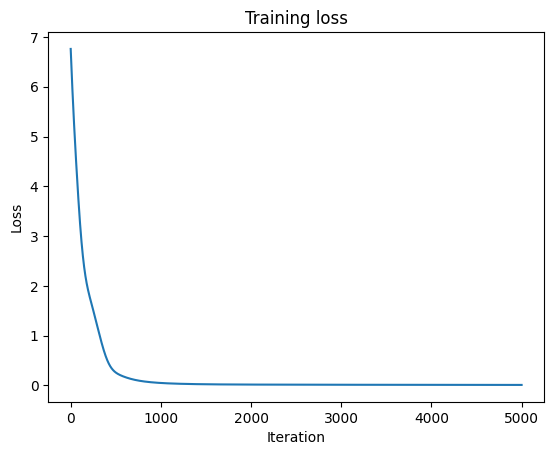

In [10]:
plt.figure()
plt.plot(LOSS)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss');

In [11]:
# Visualization
with torch.no_grad():
    y_pred_test = model(X_test)

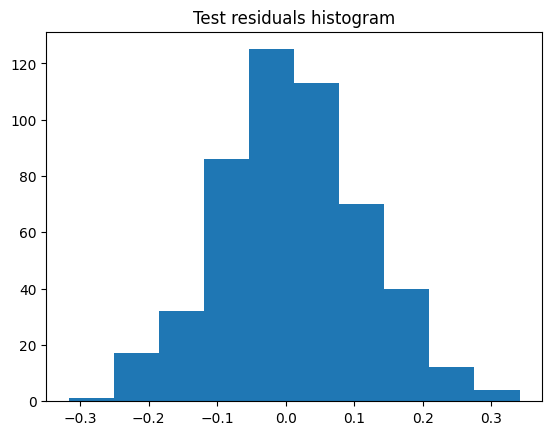

In [12]:
plt.figure()
plt.title("Test residuals histogram")
plt.hist(y_test.numpy() - y_pred_test.numpy());

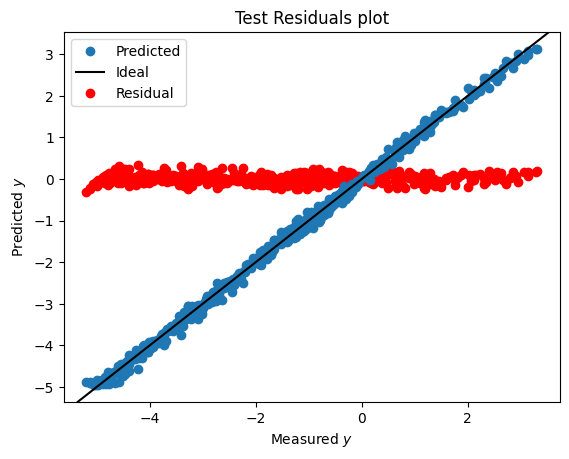

In [13]:
plt.figure()
plt.title('Test Residuals plot')
plt.plot(y_test, y_pred_test, 'o', label='Predicted', zorder=1)
plt.axline((1, 1), slope=1, color="k", label="Ideal", zorder=2) # the ideal diagonal prediction
plt.plot(y_test, y_test - y_pred_test, 'ro', label='Residual', zorder=0)
plt.legend()
plt.xlabel('Measured $y$')
plt.ylabel('Predicted $y$');

In [14]:
with torch.no_grad():
    y_true_grid = f(X_grid)
    y_pred_grid = model(X_grid).squeeze(-1)

y_true_grid.shape, y_pred_grid.shape

(torch.Size([10000]), torch.Size([10000]))

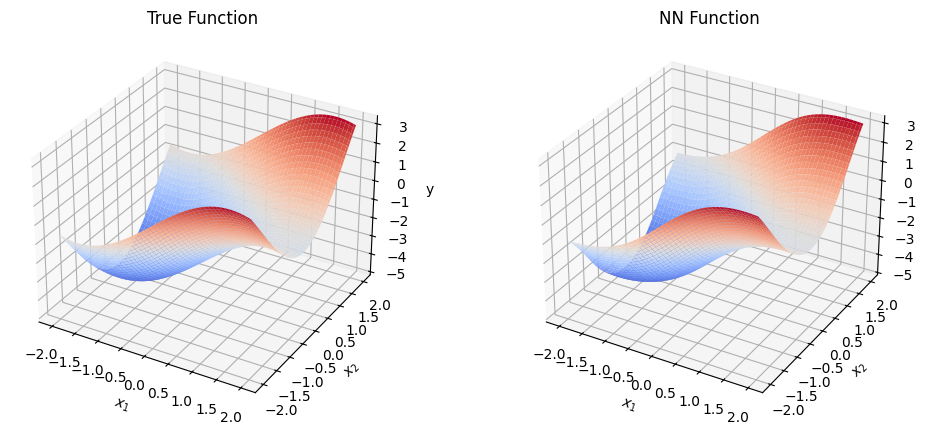

In [15]:
# 3D Plot of True Function
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_grid, X2_grid, y_grid.view(grid_points, grid_points), cmap='coolwarm', edgecolor='none')
ax1.set_title("True Function")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_zlabel("y")

# 3D Plot of NN Predictions
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1_grid, X2_grid, y_pred_grid.view(grid_points, grid_points), cmap='coolwarm', edgecolor='none')
ax2.set_title("NN Function")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_zlabel("y");